# 2D to 3D Lifting Network

## Imports and Setup

In [14]:
import os
import src.bug_dataset
import numpy as np
import pandas as pd
from skimage import io
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def set_axes_equal(ax):
    # workaround, as matplotlib's 3D plot has no option for equisised axes (10/2021)
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [16]:
target_dir = "../data/single_sungaya/"
out_df = pd.read_hdf(os.path.join(target_dir, "Data_3D_Pose.hdf5"))

In [17]:
sungaya_dataset = src.bug_dataset.BugDataset(df=out_df,
                             root_dir=target_dir,transform=transforms.Compose([
                                src.bug_dataset.ToTensor()
                                   ]))

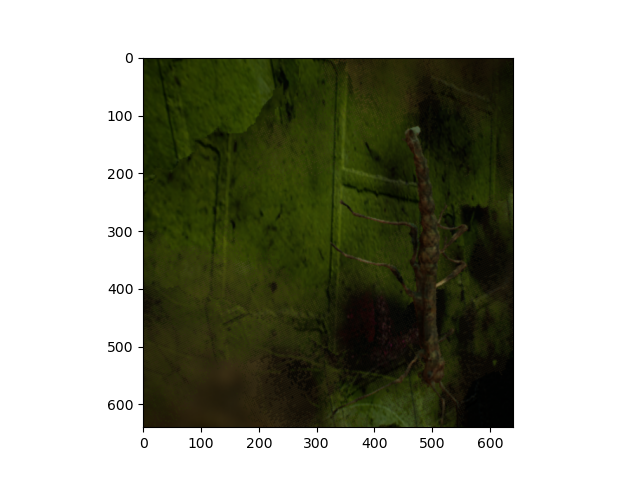

In [18]:
# sample = sungaya_dataset[1]
# # print(sample)
# image = sample["file_name"]
# plt.figure()
# plt.imshow(io.imread(os.path.join(target_dir,image)))
# plt.show()

In [19]:
train_split = 0.7
valid_split = 0.1
train_size = int(train_split * len(sungaya_dataset))
valid_size = int(valid_split * len(sungaya_dataset))
test_size = len(sungaya_dataset) - (train_size+valid_size)
train_dataset,valid_dataset ,test_dataset = torch.utils.data.random_split(sungaya_dataset, [train_size, valid_size, test_size], generator=torch.Generator().manual_seed(42))

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))    
class Net(nn.Module):
    
    def __init__(self,n_inputs,hidden,n_output):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.seq1 = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, n_inputs)
        )
        self.seq2 = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden, n_inputs)
        )
        self.out = nn.Linear(n_inputs, n_output)
    def forward(self, x):
        x = self.flatten(x)
        residual = x
        out = self.seq1(x)
        out+=residual
        out = self.seq2(out)
        return self.out(x)


In [ ]:
actual_dist=[4,4,4]
accdists = np.nan_to_num(abs((actual_dist-sungaya_dataset.means_3d)/sungaya_dataset.std_3d))
accz_dists = torch.from_numpy(accdists.T[2])
#                  Body       r_1       r_2       r_3       l_1       l_2       l_3       r_an      l_an
reducedKeypoints = [0,2,3,4,6 , 7,10,13 , 14,17,20, 21,24,27, 28,31,34, 35,38,41, 42,45,48, 52,53,55, 58,59,61]

def train(dataloader, model, loss_fn, optimizer, reducedkey):
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        if reducedkey:
            X = data['key_points_2D'][:,reducedKeypoints]
            y = data['key_points_3D'][:,reducedKeypoints,2]
            mask = data['visibility'][:,reducedKeypoints].to(device)
        else:
            X = data['key_points_2D']
            y = data['key_points_3D'][:,:,2]
            mask = data['visibility'].to(device)

        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

        pred = model(X)
        loss = torch.mean(((pred - y)*mask)**2)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, reducedkey):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:
#             print(data['key_points_2D'])
            if reducedkey:
                X = data['key_points_2D'][:,reducedKeypoints]
                y = data['key_points_3D'][:,reducedKeypoints,2]
                mask = data['visibility'][:,reducedKeypoints].to(device)
            else:
                X = data['key_points_2D']
                y = data['key_points_3D'][:,:,2]
                mask = data['visibility'].to(device)

            X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
            
            pred = model(X)
            loss = torch.mean(((pred - y)*mask)**2)
            test_loss += loss.item()
            if reducedkey:
                correct += (abs(pred - y)<accz_dists[reducedKeypoints].to(device)).type(torch.float).sum().item()
            else:
                correct += (abs(pred - y)<accz_dists.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    print(f"Validation Error: \n Accuracy: {(correct / size):>4f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
reduceKeypoints = False
if reduceKeypoints:
    model = Net(2*29,1392,29).to(device)
else:
    model = Net(2*62,512,62).to(device)

epochs = 1
learning_rate =5e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, reduceKeypoints)
    test(valid_dataloader, model, loss_fn, reduceKeypoints)
print("Done!")

In [ ]:
model.eval()
# Code get the first batch of results
with torch.no_grad():
    for data in test_dataloader:
        image = data['file_name']
        print(image)
        X = data['key_points_2D']
        y = data['key_points_3D']
        vis = data['visibility']
        # print(y)
        X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        pred = model(X)
        break


In [ ]:
def plot_stick_bug(ax, points, vis, prediction=False):
    limb_ranges=[[0,7],[8,14],[15,21],[22,28],[29,35],[36,42],[43,49],[53,56],[59,62]]
    if len(points) < 62:
        return
    elif len(points) == 62:
        points = np.array(points).T
        for num in range(len(limb_ranges)):
            visible_limb = []
            for x in range(limb_ranges[num][0],limb_ranges[num][1]):
                if vis[x]== 1:
                    visible_limb.append(x) 
            if prediction:
                ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb],'--', alpha=0.7, color='red')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='X',s=10, color='red')
            else:
                ax.plot(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], color='blue')
                ax.scatter(points[0][visible_limb], points[1][visible_limb], points[2][visible_limb], marker='o',s=4, color='blue')
        return ax


In [ ]:
sample = 0
# print(image[sample])
prediction = (pred[sample].cpu()).numpy()
actual = (y[sample].cpu()).numpy()

visibility_mask = vis[sample]
mean = sungaya_dataset.means_3d[:,2]
std = sungaya_dataset.std_3d[:,2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

unnormalised_acc = (actual*sungaya_dataset.std_3d)+sungaya_dataset.means_3d
plot_stick_bug(ax, unnormalised_acc, visibility_mask)


unnormalised_est = unnormalised_acc
unnormalised_est[:,2] = (prediction*std)+mean
plot_stick_bug(ax, unnormalised_acc, visibility_mask, True)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# use custom function to ensure equal axis proportions
set_axes_equal(ax)

# opens external plot
plt.show()